In [1]:
import xarray as xr
import rioxarray
import numpy as np
import os
import re
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import time
import json
from hlsstack.hls_funcs import fetch
from hlsstack.hls_funcs.masks import mask_hls, shp2mask, bolton_mask_xr
from hlsstack.hls_funcs.indices import ndvi_func, dfi_func, ndti_func, satvi_func, ndii7_func
from hlsstack.hls_funcs.indices import bai_126_func, bai_136_func, bai_146_func, bai_236_func, bai_246_func, bai_346_func
from hlsstack.hls_funcs.smooth import smooth_xr, despike_ts_xr

In [2]:
outPATH = 'data/bm_extract/TB_all_bm_veg_idxs.csv'

veg_dict = {
    'ndvi': ndvi_func,
    'dfi': dfi_func,
    'ndti': ndti_func,
    'satvi': satvi_func,
    'ndii7': ndii7_func,
    'bai_126': bai_126_func,
    'bai_136': bai_136_func,
    'bai_146': bai_146_func,
    'bai_236': bai_236_func,
    'bai_246': bai_246_func,
    'bai_346': bai_346_func
}

band_list = ['NIR1', 'SWIR1', 'SWIR2']

In [3]:
print('   setting up Local cluster...')
from dask.distributed import LocalCluster, Client
import dask
aws=False
fetch.setup_env(aws=aws)
cluster = LocalCluster(n_workers=8, threads_per_worker=2)
client = Client(cluster)
display(client)

   setting up Local cluster...


2025-05-07 10:12:19,361 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-wvo1eib2', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36521,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.37 GiB
Comm: tcp://127.0.0.1:38019,Total threads: 2
Dashboard: http://127.0.0.1:46305/status,Memory: 1.92 GiB
Nanny: tcp://127.0.0.1:39599,


In [4]:
# load csv of ground data
df_aoi_txt = pd.read_csv('data/bm_extract/TB_all_bm.csv', parse_dates=[1])
# drop NEX transects in ungulate exclosures
df_aoi_txt = df_aoi_txt[~df_aoi_txt['ID'].str.contains('ungulate ex')]

# convert to GeoDataFrame using coordinates
gdf_aoi = gpd.GeoDataFrame(
    df_aoi_txt, geometry=gpd.points_from_xy(df_aoi_txt['gps_E'], df_aoi_txt['gps_N']))
# set the coordinate system
gdf_aoi = gdf_aoi.set_crs(epsg=32613)
# buffer the points to extract surrounding pixels later
gdf_aoi.geometry = gdf_aoi.buffer(150)
# convert the 'Date' column to date instead of timestamp
gdf_aoi['Date'] = gdf_aoi['Date'].dt.date

gdf_excl = gpd.read_file('data/shps/TBRI_study_areas_26jun2015.shp')
gdf_excl = gdf_excl.to_crs(epsg=32613)
gdf_excl = gdf_excl[(gdf_excl['Name'].notnull()) & (gdf_excl['Exclosure'] == 'Livestock Ex')]
gdf_excl['ID'] = gdf_excl.apply(lambda x: '-'.join([x['Name'].lower(), 
                                                    x['Disturbanc'].lower(), 
                                                    x['Exclosure'].lower()]), axis=1)
gdf_excl['ID'] = gdf_excl['ID'].transform(lambda x: re.sub('priarie', 'prairie', x))

In [5]:
if os.path.exists(outPATH):
    df_out = pd.read_csv(outPATH)
    gdf_aoi_sub = gdf_aoi[~gdf_aoi['ID'].isin(df_out['ID'])]
else:
    df_out = None
    gdf_aoi_sub = gdf_aoi

In [6]:
gdf_aoi_sub

,ID,Date,Project,gps_E,gps_N,Method,bm_gm2,geometry
532,Center_Owens_Pt1_No,2019-06-13,WTGN,488527.781000,4.795777e+06,clip,192.760000,"POLYGON ((488677.781 4795776.630, 488677.059 4..."
533,Center_Owens_Pt1_No,2020-06-22,WTGN,488527.781000,4.795777e+06,clip,193.400000,"POLYGON ((488677.781 4795776.630, 488677.059 4..."
534,Center_Owens_Pt1_No,2020-06-22,WTGN,488527.781000,4.795777e+06,vor,84.211636,"POLYGON ((488677.781 4795776.630, 488677.059 4..."
535,Center_Owens_Pt1_No,2021-06-28,WTGN,488527.781000,4.795777e+06,clip,115.768000,"POLYGON ((488677.781 4795776.630, 488677.059 4..."
536,Center_Owens_Pt1_No,2022-06-27,WTGN,488527.781000,4.795777e+06,vor,224.745569,"POLYGON ((488677.781 4795776.630, 488677.059 4..."
...,...,...,...,...,...,...,...,...
4234,wildcat-prairie dog-out,2023-07-13,NEX,517132.712854,4.836233e+06,vor,181.285188,"POLYGON ((517282.713 4836232.742, 517281.991 4..."
4235,wildcat-prairie dog-out,2023-08-09,NEX,517132.712854,4.836233e+06,clip,231.568000,"POLYGON ((517282.713 4836232.742, 517281.991 4..."
4236,wildcat-prairie dog-out,2024-07-02,NEX,517132.712854,4.836233e+06,clip,196.773333,"POLYGON ((517282.713 4836232.742, 517281.991 4..."
4237,wildcat-prairie dog-out,2024-07-03,NEX,517132.712854,4.836233e+06,vor,116.892611,"POLYGON ((517282.713 4836232.742, 517281.991 4..."


In [7]:
%%time
for idx, gdf_plot in tqdm(gdf_aoi_sub.iterrows(), total=gdf_aoi_sub.shape[0]):
    print(gdf_plot['ID'], ': ', gdf_plot['Date'])

    ### fetch the COG data
    # get the data range for the fetch
    if gdf_plot.Date.year < 2017:
        start_date = gdf_plot.Date - timedelta(days=60)
        end_date = gdf_plot.Date + timedelta(days=60)
    elif gdf_plot.Date.year == 2017:
        start_date = gdf_plot.Date - timedelta(days=50)
        end_date = gdf_plot.Date + timedelta(days=50)
    elif gdf_plot.Date.year > 2017:
        start_date = gdf_plot.Date - timedelta(days=45)
        end_date = gdf_plot.Date + timedelta(days=45)
    data_dict = {'date_range': [str(start_date), 
                                str(end_date)]}
    idx_load_try = 0
    max_load_try = 5
    while idx_load_try < max_load_try:
        try:
            # fetch the data
            hls_ds = fetch.get_hls(hls_data=data_dict,
                                   bbox=np.array(gdf_plot.geometry.bounds), 
                                   stack_chunks=(400, 400),
                                   proj_epsg=gdf_aoi.crs.to_epsg(),
                                   lim=1000,
                                   aws=aws).drop_vars(['SZA', 'SAA', 'VZA', 'VAA']).chunk({'time': -1}).persist()

            # mask the dataset using the native HLS mask
            hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
            hls_ds = hls_ds.where(hls_mask == 0, drop=True)

            # mask the dataset using the Bolton mask
            #hls_bolton_mask = bolton_mask_xr(hls_ds)
            #hls_ds = hls_ds.where(hls_bolton_mask == 0, drop=True)

            # pick best image for any dates with duplicate images
            if len(np.unique(hls_ds.time.values)) < len(hls_ds.time.values):
                print('    reducing along id dimension to single observation for each date, keeping least-masked image')
                hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
                hls_ds['maskcov_pct'] = ((hls_mask != 0).sum(['y', 'x']) / hls_ds['FMASK'].isel(time=0).size * 100)#
                hls_ds = hls_ds.groupby('maskcov_pct').apply(
                    lambda x: x.sortby('maskcov_pct')).drop_duplicates(
                    'time', keep='first').sortby('time').drop_vars('maskcov_pct')

            hls_ds['time'] = pd.to_datetime(hls_ds['time'])
            hls_ds['time'] = hls_ds['time'].dt.date
            hls_ds = hls_ds.reset_coords(drop=True).drop_vars('FMASK')

            hls_ds['dist'] = np.sqrt((hls_ds['y'] - gdf_plot['gps_N'])**2 + ((hls_ds['x'] - gdf_plot['gps_E'])**2))

            hls_ds = hls_ds.set_coords('dist')#.sortby('dist')

            if gdf_plot['Project'] == 'NEX':
                print('masking livestock exclosure')
                gdf_excl_plot = gdf_excl[gdf_excl['ID'] == re.sub('out', 'livestock ex', gdf_plot['ID'])]
                excl_info = gdf_excl_plot[['ID', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
                excl_mask_shp = [(row.geometry, 1) for _, row in excl_info.iterrows()]
                excl_mask = shp2mask(shp=excl_mask_shp, 
                                     transform=hls_ds.rio.transform(), 
                                     outshape=hls_ds['BLUE'].shape[1:], 
                                     xr_object=hls_ds['BLUE'])
                if gdf_plot['ID'].split('-')[-1] == 'livestock ex':
                    hls_ds = hls_ds.where(excl_mask == 1)
                elif gdf_plot['ID'].split('-')[-1] == 'out':
                    hls_ds = hls_ds.where(excl_mask == 0)
            
            max_dist = hls_ds.stack(z=['y', 'x']).where(
                hls_ds.stack(z=['y', 'x']).notnull(), drop=True).sortby('dist').isel(
                z=3)['dist']
            
            hls_plot = hls_ds.where(hls_ds['dist'] <= max_dist)

            hls_plot = hls_plot.where(hls_plot['BLUE'].notnull(), drop=True).compute()
            idx_load_try = max_load_try
            
        except RuntimeError as e:            
            print('Warning: error connecting to lpdaac. Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
            client.restart()
            idx_load_try += 1
            time.sleep(10)
            
        except rio.errors.RasterioIOError as e:
            print('Warning: error loading data. Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
            client.restart()
            idx_load_try += 1
            time.sleep(10)
        
        except json.decoder.JSONDecodeError:
            print('Warning: JSON decoding error (usually related to 502 Bad Gateway error).',
                  'Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
            client.restart()
            idx_load_try += 1
            time.sleep(10)

    print('   creating daily template for output...')
    # set the date range for analysis
    date_rng = pd.date_range(start=start_date, end=end_date)

    # create empty numpy array matching plot xarray dims
    dat_out_nans = np.zeros((len([x.date() for x in date_rng if x.date() not in hls_plot['time'].values]), 
                             hls_plot.dims['y'], 
                             hls_plot.dims['x'])) * np.nan

    # create dictionary to map variables to data and coords
    xr_empty_dict = {}
    for veg in veg_dict:
        xr_empty_dict[veg] = (['time', 'y', 'x'],
                                   dat_out_nans)
    for band in band_list:
        xr_empty_dict[band] = (['time', 'y', 'x'],
                                   dat_out_nans)

    # create the empty xarray Dataset for dates without imagery
    ds_empty = xr.Dataset(data_vars=xr_empty_dict,
                          coords={'time': [x.date() for x in date_rng if x.date() not in hls_plot['time'].values],
                                  'x': hls_plot.x,
                                  'y': hls_plot.y})

    xr_veg_list = []
    for veg in veg_dict:
        xr_veg_tmp = veg_dict[veg](hls_plot)
        xr_veg_tmp.name = veg
        xr_veg_list.append(xr_veg_tmp)
    for band in band_list:
        xr_veg_tmp = hls_plot[band]
        xr_veg_tmp.name = band
        xr_veg_list.append(xr_veg_tmp)

    ds_plot = xr.merge(xr_veg_list)

    ds_plot = xr.concat([ds_empty, ds_plot], dim='time').sortby('time').chunk({'time': -1, 'y': 1, 'x': 1})

    ds_plot['time'] = pd.to_datetime(ds_plot['time'])
    ds_plot['time'] = ds_plot['time'].dt.date

    ds_plot['ndvi'] = despike_ts_xr(ds_plot['ndvi'], dims=['time'], dat_thresh=0.075, days_thresh=60).persist()

    ds_plot = ds_plot.where(ds_plot['ndvi'].notnull())

    ds_plot_smooth = ds_plot.map(smooth_xr, dims=['time'])
    
    ds_plot_smooth = ds_plot_smooth.stack(z=['y', 'x'])
    ds_plot_smooth = ds_plot_smooth.where(ds_plot_smooth['dist'].notnull(), drop=True)

    df_plot_tmp = ds_plot_smooth.sel(
        time=[gdf_plot['Date']]).weighted(
        ds_plot_smooth.dist).mean('z').rename({'time':
                                                      'Date'}).to_dataframe().reset_index()
    df_plot_out = pd.merge(gdf_plot.to_frame().transpose(), df_plot_tmp, left_on='Date', right_on='Date')
    df_plot_out = df_plot_out.rename(columns={'NIR1': 'nir',
                                              'SWIR1': 'swir1',
                                              'SWIR2': 'swir2'})
    
    if df_out is None:
        print('creating initial dataframe')
        df_out = df_plot_out
    else:
        df_out = pd.concat([df_out, df_plot_out])
        df_out.to_csv('data/bm_extract/TB_all_bm_veg_idxs.csv', index=False)
    if idx%50 == 0:
        client.restart()

  0%|          | 0/3425 [00:00<?, ?it/s]

Center_Owens_Pt1_No :  2019-06-13
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt1_No :  2020-06-22
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt1_No :  2020-06-22
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt1_No :  2021-06-28
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt1_No :  2022-06-27
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt1_No :  2022-08-08
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating dai

2025-05-07 10:22:14,066 - distributed.scheduler - ERROR - Error transitioning "('xarray-dist-ba370bd1d929b80752db16f624ec9ce5', 2, 0)" from 'processing' to 'memory'
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.9/site-packages/distributed/scheduler.py", line 1853, in _transition
    recommendations, client_msgs, worker_msgs = func(
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.9/site-packages/distributed/scheduler.py", line 2293, in transition_processing_memory
    raise RuntimeError(
RuntimeError: Task "('xarray-dist-ba370bd1d929b80752db16f624ec9ce5', 2, 0)" transitioned from processing to memory on worker <WorkerState 'tcp://127.0.0.1:38153', name: 5, status: running, memory: 3, processing: 1>, while it was expected from <WorkerState 'tcp://127.0.0.1:41827', name: 6, status: running, memory: 2, processing: 3>. This should be impossible. stimulus_id='task-finished-1746638534.0387683', story=[Transition(key="('xarra

   creating daily template for output...


2025-05-07 10:22:16,099 - distributed.nanny - ERROR - Worker process died unexpectedly


Center_Owens_Pt2_No :  2022-08-08
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt3_No :  2019-06-13
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt3_No :  2020-06-22
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt3_No :  2020-06-22
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt3_No :  2021-06-21
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt3_No :  2021-06-21
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating dai

2025-05-07 10:29:50,457 - distributed.nanny - WARNING - Restarting worker
2025-05-07 10:29:50,472 - distributed.nanny - WARNING - Restarting worker
2025-05-07 10:29:50,487 - distributed.nanny - WARNING - Restarting worker
2025-05-07 10:29:50,503 - distributed.nanny - WARNING - Restarting worker
2025-05-07 10:29:50,505 - distributed.nanny - WARNING - Restarting worker
2025-05-07 10:29:50,514 - distributed.nanny - WARNING - Restarting worker
2025-05-07 10:29:50,525 - distributed.nanny - WARNING - Restarting worker


Center_Owens_Pt3_No :  2022-08-08
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt4_No :  2019-06-11
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt4_No :  2020-06-22
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt4_No :  2021-06-22
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt4_No :  2022-06-27
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Center_Owens_Pt5_No :  2019-06-12
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating dai

2025-05-07 11:08:02,361 - distributed.scheduler - ERROR - Error transitioning "('xarray-dist-609cd3c4c53e1d0cc9d3907cf606a073', 1, 1)" from 'processing' to 'memory'
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.9/site-packages/distributed/scheduler.py", line 1853, in _transition
    recommendations, client_msgs, worker_msgs = func(
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.9/site-packages/distributed/scheduler.py", line 2293, in transition_processing_memory
    raise RuntimeError(
RuntimeError: Task "('xarray-dist-609cd3c4c53e1d0cc9d3907cf606a073', 1, 1)" transitioned from processing to memory on worker <WorkerState 'tcp://127.0.0.1:37145', name: 1, status: running, memory: 2, processing: 3>, while it was expected from <WorkerState 'tcp://127.0.0.1:39387', name: 2, status: running, memory: 1, processing: 4>. This should be impossible. stimulus_id='task-finished-1746641282.325905', story=[Transition(key="('xarray

   creating daily template for output...


2025-05-07 11:08:04,379 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-05-07 11:08:06,032 - distributed.nanny - WARNING - Restarting worker
2025-05-07 11:08:06,061 - distributed.nanny - WARNING - Restarting worker
2025-05-07 11:08:06,077 - distributed.nanny - WARNING - Restarting worker
2025-05-07 11:08:06,079 - distributed.nanny - WARNING - Restarting worker
2025-05-07 11:08:06,102 - distributed.nanny - WARNING - Restarting worker
2025-05-07 11:08:06,108 - distributed.nanny - WARNING - Restarting worker


E10.1 :  2019-06-17
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.2 :  2015-06-13
   creating daily template for output...
E10.2 :  2016-08-09
   creating daily template for output...
E10.2 :  2017-07-04
   creating daily template for output...
E10.2 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.2 :  2019-06-17
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.3 :  2015-06-13
   creating daily template for output...
E10.3 :  2016-08-09
   creating daily template for output...
E10.3 :  2017-07-04
   creating daily template for output...
E10.3 :  2017-08-01
   creating daily template for output...
E10.3 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least

2025-05-07 11:23:06,225 - distributed.scheduler - ERROR - Error transitioning "('xarray-dist-a98dcd480d4af4ebd9147ba618862038', 1, 1)" from 'processing' to 'memory'
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.9/site-packages/distributed/scheduler.py", line 1853, in _transition
    recommendations, client_msgs, worker_msgs = func(
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.9/site-packages/distributed/scheduler.py", line 2293, in transition_processing_memory
    raise RuntimeError(
RuntimeError: Task "('xarray-dist-a98dcd480d4af4ebd9147ba618862038', 1, 1)" transitioned from processing to memory on worker <WorkerState 'tcp://127.0.0.1:42097', name: 2, status: running, memory: 1, processing: 2>, while it was expected from <WorkerState 'tcp://127.0.0.1:34541', name: 4, status: running, memory: 5, processing: 8>. This should be impossible. stimulus_id='task-finished-1746642186.1804943', story=[Transition(key="('xarra

   creating daily template for output...


2025-05-07 11:23:06,272 - distributed.scheduler - ERROR - Error transitioning "('xarray-dist-a98dcd480d4af4ebd9147ba618862038', 1, 2)" from 'processing' to 'memory'
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.9/site-packages/distributed/scheduler.py", line 1853, in _transition
    recommendations, client_msgs, worker_msgs = func(
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.9/site-packages/distributed/scheduler.py", line 2293, in transition_processing_memory
    raise RuntimeError(
RuntimeError: Task "('xarray-dist-a98dcd480d4af4ebd9147ba618862038', 1, 2)" transitioned from processing to memory on worker <WorkerState 'tcp://127.0.0.1:43061', name: 7, status: running, memory: 2, processing: 3>, while it was expected from <WorkerState 'tcp://127.0.0.1:34541', name: 4, status: running, memory: 5, processing: 8>. This should be impossible. stimulus_id='task-finished-1746642186.1809492', story=[Transition(key="('xarra

E10.5 :  2015-06-14
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.5 :  2016-08-09
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.5 :  2017-07-04
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.5 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.5 :  2019-06-17
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.6 :  2015-06-14
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.6 :  2016-08-09
    reducing along id dimension to sin

2025-05-07 11:32:23,021 - distributed.scheduler - ERROR - Error transitioning "('xarray-dist-72901dee747b8c5883fcf6e0ae754fe7', 1, 0)" from 'processing' to 'memory'
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.9/site-packages/distributed/scheduler.py", line 1853, in _transition
    recommendations, client_msgs, worker_msgs = func(
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.9/site-packages/distributed/scheduler.py", line 2293, in transition_processing_memory
    raise RuntimeError(
RuntimeError: Task "('xarray-dist-72901dee747b8c5883fcf6e0ae754fe7', 1, 0)" transitioned from processing to memory on worker <WorkerState 'tcp://127.0.0.1:34541', name: 4, status: running, memory: 7, processing: 1>, while it was expected from <WorkerState 'tcp://127.0.0.1:37791', name: 0, status: running, memory: 8, processing: 5>. This should be impossible. stimulus_id='task-finished-1746642742.9847453', story=[Transition(key="('xarra

   creating daily template for output...


2025-05-07 11:32:25,040 - distributed.nanny - ERROR - Worker process died unexpectedly


E10.6 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.6 :  2019-06-18
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.7 :  2015-06-14
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.7 :  2016-08-09
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.7 :  2017-07-04
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.7 :  2017-08-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E10.7 :  2018-07-01
    reducing along id dimension to sin

2025-05-07 11:48:26,775 - distributed.nanny - WARNING - Restarting worker
2025-05-07 11:48:26,841 - distributed.nanny - WARNING - Restarting worker


E11.2 :  2019-06-19
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E11.3 :  2015-08-12
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E11.3 :  2016-07-22
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E11.3 :  2017-07-28
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E11.3 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E11.3 :  2019-06-19
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E11.4 :  2015-08-12
   creating daily template for output.

2025-05-07 12:01:14,518 - distributed.scheduler - ERROR - Error transitioning "('xarray-dist-318300442311e00b7130462065c650db', 0, 0)" from 'processing' to 'memory'
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.9/site-packages/distributed/scheduler.py", line 1853, in _transition
    recommendations, client_msgs, worker_msgs = func(
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.9/site-packages/distributed/scheduler.py", line 2293, in transition_processing_memory
    raise RuntimeError(
RuntimeError: Task "('xarray-dist-318300442311e00b7130462065c650db', 0, 0)" transitioned from processing to memory on worker <WorkerState 'tcp://127.0.0.1:39929', name: 3, status: running, memory: 6, processing: 2>, while it was expected from <WorkerState 'tcp://127.0.0.1:42061', name: 0, status: running, memory: 7, processing: 6>. This should be impossible. stimulus_id='task-finished-1746644474.477379', story=[Transition(key="('xarray

   creating daily template for output...


2025-05-07 12:01:16,539 - distributed.nanny - ERROR - Worker process died unexpectedly


E11.5 :  2015-08-11
   creating daily template for output...
E11.5 :  2016-07-22
   creating daily template for output...
E11.5 :  2017-07-28
   creating daily template for output...
E11.5 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E11.5 :  2019-06-19
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E11.6 :  2015-08-11
   creating daily template for output...
E11.6 :  2016-07-22
   creating daily template for output...
E11.6 :  2017-07-28
   creating daily template for output...
E11.6 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E11.6 :  2019-06-19
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E12.1 

2025-05-07 12:31:52,756 - distributed.nanny - WARNING - Restarting worker


E12.6 :  2019-06-17
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E12.7 :  2015-07-30
   creating daily template for output...
E12.7 :  2016-07-22
   creating daily template for output...
E12.7 :  2017-07-14
   creating daily template for output...
E12.7 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E12.7 :  2019-06-17
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E12.8 :  2015-07-30
   creating daily template for output...
E12.8 :  2016-07-22
   creating daily template for output...
E12.8 :  2017-07-14
   creating daily template for output...
E12.8 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E12.8 

NameError: name 'rio' is not defined

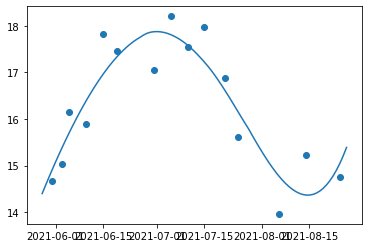

In [21]:
import matplotlib.pyplot as plt
plt.plot(ds_plot_smooth.time, ds_plot_smooth.dfi.mean('z').values)
plt.scatter(x=ds_plot.time, y=ds_plot.dfi.mean(['y', 'x']).values)

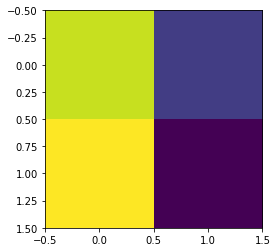

<AxesSubplot:>

In [25]:
from rasterio.plot import show
show(ds_plot_smooth.unstack().ndvi.isel(time=45).data)

In [173]:
# fetch the data
hls_ds = fetch.get_hls(hls_data=data_dict,
                       bbox=np.array(gdf_plot.geometry.bounds), 
                       stack_chunks=(400, 400),
                       proj_epsg=gdf_aoi.crs.to_epsg(),
                       lim=1000,
                       aws=aws).drop_vars(['SZA', 'SAA', 'VZA', 'VAA']).chunk({'time': -1}).persist()

# mask the dataset using the native HLS mask
hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
hls_ds = hls_ds.where(hls_mask == 0, drop=True)

# mask the dataset using the Bolton mask
#hls_bolton_mask = bolton_mask_xr(hls_ds)
#hls_ds = hls_ds.where(hls_bolton_mask == 0, drop=True)

# pick best image for any dates with duplicate images
if len(np.unique(hls_ds.time.values)) < len(hls_ds.time.values):
    print('    reducing along id dimension to single observation for each date, keeping least-masked image')
    hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
    hls_ds['maskcov_pct'] = ((hls_mask != 0).sum(['y', 'x']) / hls_ds['FMASK'].isel(time=0).size * 100)#
    hls_ds = hls_ds.groupby('maskcov_pct').apply(
        lambda x: x.sortby('maskcov_pct')).drop_duplicates(
        'time', keep='first').sortby('time').drop_vars('maskcov_pct')

hls_ds['time'] = pd.to_datetime(hls_ds['time'])
hls_ds['time'] = hls_ds['time'].dt.date
hls_ds = hls_ds.reset_coords(drop=True).drop_vars('FMASK')

hls_ds['dist'] = np.sqrt((hls_ds['y'] - gdf_plot['gps_N'])**2 + ((hls_ds['x'] - gdf_plot['gps_E'])**2))

hls_ds = hls_ds.set_coords('dist')#.sortby('dist')

if gdf_plot['Project'] == 'NEX':
    print('masking livestock exclosure')
    gdf_excl_plot = gdf_excl[gdf_excl['ID'] == re.sub('out', 'livestock ex', gdf_plot['ID'])]
    excl_info = gdf_excl_plot[['ID', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
    excl_mask_shp = [(row.geometry, 1) for _, row in excl_info.iterrows()]
    excl_mask = shp2mask(shp=excl_mask_shp, 
                         transform=hls_ds.transform, 
                         outshape=hls_ds['BLUE'].shape[1:], 
                         xr_object=hls_ds['BLUE'])
    if gdf_plot['ID'].split('-')[-1] == 'livestock ex':
        hls_ds = hls_ds.where(excl_mask == 1)
    elif gdf_plot['ID'].split('-')[-1] == 'out':
        hls_ds = hls_ds.where(excl_mask == 0)

max_dist = hls_ds.stack(z=['y', 'x']).where(
    hls_ds.stack(z=['y', 'x']).notnull(), drop=True).sortby('dist').isel(
    z=3)['dist']

hls_plot = hls_ds.where(hls_ds['dist'] <= max_dist)

hls_plot = hls_plot.where(hls_plot['BLUE'].notnull(), drop=True).compute()

    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure


In [174]:
hls_plot

<xarray.Dataset>
Dimensions:  (time: 15, y: 2, x: 2)
Coordinates:
  * time     (time) object 2021-05-31 2021-06-03 ... 2021-08-14 2021-08-24
  * x        (x) float64 5.171e+05 5.171e+05
  * y        (y) float64 4.836e+06 4.836e+06
    dist     (y, x) float64 23.84 10.29 32.14 23.88
    z        object (4836210.0, 517110.0)
Data variables:
    BLUE     (time, y, x) float64 707.0 621.0 714.0 637.0 ... 564.0 726.0 564.0
    GREEN    (time, y, x) float64 989.0 874.0 984.0 884.0 ... 802.0 998.0 788.0
    RED      (time, y, x) float64 1.175e+03 1.045e+03 ... 1.169e+03 892.0
    NIR1     (time, y, x) float64 2.061e+03 1.978e+03 ... 2.227e+03 1.992e+03
    SWIR1    (time, y, x) float64 3.421e+03 3.204e+03 ... 3.524e+03 3.069e+03
    SWIR2    (time, y, x) float64 2.592e+03 2.281e+03 ... 2.528e+03 2.061e+03
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(516960, 4836060, 517290, 4836...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 516960.00|\n| 0.00,-30.00, 4836390.00|\n| 0.0...
    resolution:  30

In [104]:
gdf_plot_test = gdf_aoi[gdf_aoi['ID'] == 'west fork-prairie dog-livestock ex'].iloc[-1]
gdf_excl = gpd.read_file('data/shps/TBRI_study_areas_26jun2015.shp')
gdf_excl = gdf_excl.to_crs(epsg=32613)
gdf_excl = gdf_excl[(gdf_excl['Name'].notnull()) & (gdf_excl['Exclosure'] == 'Livestock Ex')]
gdf_excl['ID'] = gdf_excl.apply(lambda x: '-'.join([x['Name'].lower(), 
                                                    x['Disturbanc'].lower(), 
                                                    x['Exclosure'].lower()]), axis=1)
gdf_excl['ID'] = gdf_excl['ID'].transform(lambda x: re.sub('priarie', 'prairie', x))

In [162]:
start_date = gdf_plot_test.Date - timedelta(days=45)
data_dict_test = {'date_range': [str(start_date), 
                                 str(start_date + timedelta(days=5))]}
# fetch the data
hls_ds_test = fetch.get_hls(hls_data=data_dict,
                       bbox=np.array(gdf_plot_test.geometry.buffer(200).bounds), 
                       stack_chunks=(400, 400),
                       proj_epsg=gdf_aoi.crs.to_epsg(),
                       lim=1000,
                       aws=aws).drop_vars(['SZA', 'SAA', 'VZA', 'VAA']).chunk({'time': -1}).persist()

# mask the dataset using the native HLS mask
hls_mask = mask_hls(hls_ds_test['FMASK'], mask_types=['all'])
hls_ds_test = hls_ds_test.where(hls_mask == 0, drop=True)

# mask the dataset using the Bolton mask
#hls_bolton_mask = bolton_mask_xr(hls_ds_test)
#hls_ds_test = hls_ds_test.where(hls_bolton_mask == 0, drop=True)

# pick best image for any dates with duplicate images
if len(np.unique(hls_ds_test.time.values)) < len(hls_ds_test.time.values):
    print('    reducing along id dimension to single observation for each date, keeping least-masked image')
    hls_mask = mask_hls(hls_ds_test['FMASK'], mask_types=['all'])
    hls_ds_test['maskcov_pct'] = ((hls_mask != 0).sum(['y', 'x']) / hls_ds_test['FMASK'].isel(time=0).size * 100)#
    hls_ds_test = hls_ds_test.groupby('maskcov_pct').apply(
        lambda x: x.sortby('maskcov_pct')).drop_duplicates(
        'time', keep='first').sortby('time').drop_vars('maskcov_pct')

hls_ds_test['time'] = pd.to_datetime(hls_ds_test['time'])
hls_ds_test['time'] = hls_ds_test['time'].dt.date
hls_ds_test = hls_ds_test.reset_coords(drop=True).drop_vars('FMASK')

hls_ds_test['dist'] = np.sqrt((hls_ds_test['y'] - gdf_plot_test['gps_N'])**2 + ((hls_ds_test['x'] - gdf_plot_test['gps_E'])**2))

hls_ds_test = hls_ds_test.set_coords('dist')#.sortby('dist')

if gdf_plot_test['Project'] == 'NEX':
    print('masking livestock exclosure')
    gdf_excl_plot = gdf_excl[gdf_excl['ID'] == re.sub('out', 'livestock ex', gdf_plot_test['ID'])]
    excl_info = gdf_excl_plot[['ID', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
    excl_mask_shp = [(row.geometry, 1) for _, row in excl_info.iterrows()]
    excl_mask = shp2mask(shp=excl_mask_shp, 
                         transform=hls_ds_test.rio.transform(), 
                         outshape=hls_ds_test['BLUE'].shape[1:], 
                         xr_object=hls_ds_test['BLUE'],
                         all_touched=False)
    if gdf_plot_test['ID'].split('-')[-1] == 'livestock ex':
        hls_ds_test = hls_ds_test.where(excl_mask == 1)
    elif gdf_plot_test['ID'].split('-')[-1] == 'out':
        hls_ds_test = hls_ds_test.where(excl_mask == 0)

    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure


In [99]:
from rasterio.features import Affine
orig_transform = hls_ds_test.rio.transform()
shift_transform = Affine(orig_transform[0], orig_transform[1], orig_transform[2]+(0.5*orig_transform[0]),
                         orig_transform[3], orig_transform[4], orig_transform[5]-(0.5*orig_transform[0]))

In [154]:
gdf_plot_test

ID                         west fork-prairie dog-livestock ex
Date                                               2021-07-13
Project                                                   NEX
gps_E                                           487230.122072
gps_N                                          4822876.010324
bm_gm2                                              89.344629
geometry    POLYGON ((487380.1220723571 4822876.010324053,...
Name: 2831, dtype: object

In [177]:
max_dist = hls_ds_test.stack(z=['y', 'x']).where(
    hls_ds_test.stack(z=['y', 'x']).notnull(), drop=True).sortby('dist').isel(
    z=3)['dist']

In [180]:
hls_ds_test['NIR1'].where((hls_ds_test['dist'] <= max_dist) & 
                          (hls_ds_test['NIR1'].notnull()), drop=True)

<xarray.DataArray 'NIR1' (time: 16, y: 2, x: 2)>
dask.array<where, shape=(16, 2, 2), dtype=float64, chunksize=(16, 2, 2), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2021-05-31 2021-06-03 ... 2021-08-14 2021-08-24
  * x        (x) float64 4.872e+05 4.872e+05
  * y        (y) float64 4.823e+06 4.823e+06
    dist     (y, x) float64 34.11 16.01 54.99 46.01
    z        object (4822830.0, 487200.0)

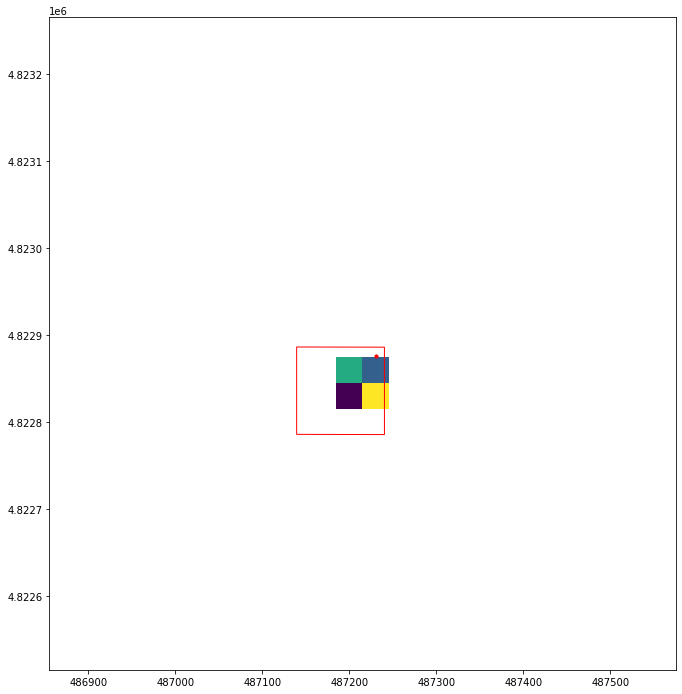

In [165]:
fig, ax = plt.subplots(figsize=(12, 12))
show(hls_ds_test['NIR1'].where(hls_ds_test['dist'] <= max_dist).isel(time=1).data, transform=hls_ds_test.rio.transform(), ax=ax)
xs, ys = gdf_excl_plot.iloc[0].geometry.exterior.xy
ax.fill(xs, ys, alpha=1, fc='none', ec='r')
ax.scatter(gdf_plot_test['gps_E'], gdf_plot_test['gps_N'], c='r', s=10)

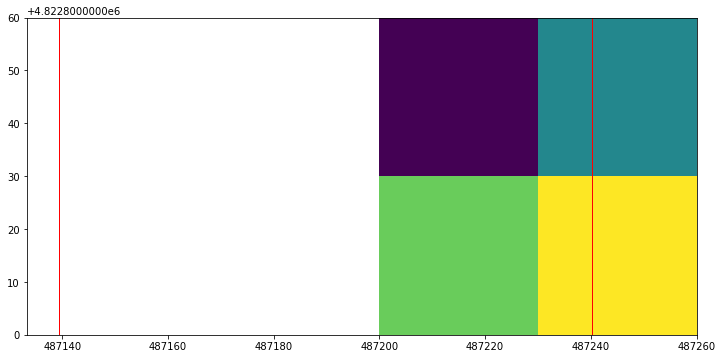

In [166]:
hls_plot = hls_ds_test.stack(z=['y', 'x']).where(
    hls_ds_test.stack(z=['y', 'x']).notnull(), drop=True).sortby('dist').isel(
    z=slice(0,4), drop=True).unstack()

hls_plot = hls_plot.where(hls_plot['BLUE'].notnull(), drop=True).compute()
fig, ax = plt.subplots(figsize=(12, 12))
#show(hls_ds_test['dist'].data, transform=hls_ds_test.transform, ax=ax)
show(hls_plot['dist'].data, transform=Affine(30.0, 0.0, hls_plot.x.min(), 0.0, -30.0, hls_plot.y.max()), ax=ax)
ax.fill(xs, ys, alpha=1, fc='none', ec='r')
ax.scatter(gdf_plot_test['gps_E'], gdf_plot_test['gps_N'], c='r', s=10)

In [112]:
hls_plot

<xarray.Dataset>
Dimensions:  (time: 16, y: 3, x: 2)
Coordinates:
  * time     (time) object 2021-05-31 2021-06-03 ... 2021-08-14 2021-08-24
    dist     (y, x) float64 33.21 61.73 34.11 nan 54.99 nan
  * y        (y) float64 4.823e+06 4.823e+06 4.823e+06
  * x        (x) float64 4.872e+05 4.872e+05
Data variables:
    BLUE     (time, y, x) float64 751.0 740.0 749.0 nan ... 570.0 nan 576.0 nan
    GREEN    (time, y, x) float64 986.0 976.0 989.0 nan ... 759.0 nan 768.0 nan
    RED      (time, y, x) float64 1.124e+03 1.11e+03 1.145e+03 ... nan 871.0 nan
    NIR1     (time, y, x) float64 1.986e+03 1.977e+03 ... 1.797e+03 nan
    SWIR1    (time, y, x) float64 3.182e+03 3.162e+03 3.18e+03 ... 2.818e+03 nan
    SWIR2    (time, y, x) float64 2.334e+03 2.298e+03 ... 1.959e+03 nan
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(486870, 4822500, 487590, 4823...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 486870.00|\n| 0.00,-30.00, 4823250.00|\n| 0.0...
    resolution:  30